In [1]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime
from sklearn.decomposition import PCA, KernelPCA
from numpy import linalg as LA
import plotly.graph_objs as go
import plotly.colors as colors
from linear_sca import *
from utils import *
import wandb
from itertools import combinations
import jPCA

In [10]:
#X = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/Churchland/churchland.npy') 
X = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
K, N, T = X.shape
print(X.shape)
split = 30
d=5

X_sca, _ = pre_processing(X, soft_normalize='max')
#X = X.swapaxes(1,2)
print(X_sca.shape)
print(compute_S_all_pairs(X_sca))

(108, 182, 35)
(108, 30, 35)
0.3764913


In [11]:
wandb.init(project="SCA-project", name="run_1", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(X_sca, d=d, iterations=500, learning_rate=0.01) # iterations, learning_rate, d               
wandb.finish()

Iteration 0, S: 70.50540924072266, S_ratio: 0.21378323435783386
Iteration 10, S: 88.57642364501953, S_ratio: 0.2732854187488556
Iteration 20, S: 157.89527893066406, S_ratio: 0.3050133287906647
Iteration 30, S: 192.97393798828125, S_ratio: 0.30639177560806274
Iteration 40, S: 247.49264526367188, S_ratio: 0.31000590324401855
Iteration 50, S: 254.1546630859375, S_ratio: 0.29249316453933716
Iteration 60, S: 424.1584777832031, S_ratio: 0.31797027587890625
Iteration 70, S: 433.1064758300781, S_ratio: 0.3128785192966461
Iteration 80, S: 541.1275634765625, S_ratio: 0.336148738861084
Iteration 90, S: 462.8782958984375, S_ratio: 0.3492007851600647
Iteration 100, S: 582.2804565429688, S_ratio: 0.3461463749408722
Iteration 110, S: 619.8750610351562, S_ratio: 0.37733519077301025
Iteration 120, S: 619.1123657226562, S_ratio: 0.34332960844039917
Iteration 130, S: 597.5398559570312, S_ratio: 0.366068959236145
Iteration 140, S: 513.4378662109375, S_ratio: 0.36435914039611816
Iteration 150, S: 619.02740

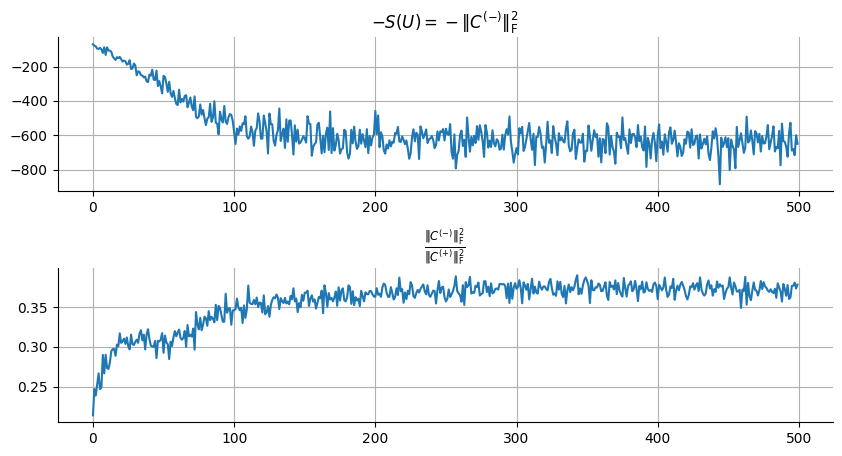

In [12]:
get_loss_fig(ls_loss, ls_S_ratio)


variance captured ratio 0.35
s: 0.3725583851337433


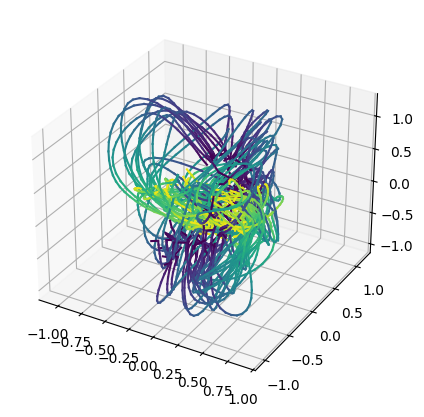

In [13]:
# s_normalized = jnp.sqrt(X.shape[1]) * (s ** 2) / jnp.linalg.norm(s ** 2)
# X_scaled = s_normalized[None, :, None] *  X

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X_sca[:,:,:])         #(K,d,T) 

print(f"variance captured ratio {var_explained(X_sca, U_qr):.2f}")
print(f's: {compute_S_all_pairs(Y)}')
plot_3D(Y)

In [ ]:
X_pca, _ = pre_processing(X, soft_normalize='max', pca=False) 
X_pca_train = np.concatenate(X_pca[split:].swapaxes(1,2))
X_pca_test = np.concatenate(X_pca[:split].swapaxes(1,2))
X_reshaped = np.concatenate(X_pca.swapaxes(1,2))

pca = PCA(d)
Y_pca = pca.fit(X_reshaped).transform(X_reshaped) #train, test 
PCs = pca.components_
Y_pca = Y_pca.reshape(K, T, d).swapaxes(1,2) #split
pca_variance_captured = pca.explained_variance_ratio_

print(f"variance captured ratio {var_explained(X_pca, PCs.T):.2f}")
print(f's = {compute_S_all_pairs(jnp.array(Y_pca))}')

plot_2D(Y_pca)

In [ ]:
""" jPCA """
X_jpca, _ = pre_processing(X, soft_normalize='max', num_pcs=6)
X_jpca_ls = [X_jpca[i].T for i in range(X_jpca.shape[0])]
times = np.arange(-50, 555, 5).tolist()                                              #(140,); but -250:445 

jpca = jPCA.JPCA(num_jpcs=d)
(projected, 
 full_data_var,
 pca_var_capt,
 jpca_var_capt) = jpca.fit(X_jpca_ls, times=times, tstart=times[0], tend=times[-1], soft_normalize=0, subtract_cc_mean=False, pca=False) 

jpcs = jpca.jpcs
print(f"variance captured ratio {var_explained(X_jpca, jpcs)}")                 #:.2f

Y_jpca = jnp.array((X_jpca_ls @ jpcs).swapaxes(1,2))
print(f's = {compute_S_all_pairs(Y_jpca)}')

plot_2D(Y_jpca)

OTHER PLOTS (3D)

In [ ]:
def make_frame(angle):
    ax.view_init(angle, 30)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0,360, 2) 
frames = [make_frame(angle) for angle in angles]

#gif_path = date_time_str + "_trajectories_rotation.gif"
gif_path = "trajectories_rotation.gif"
imageio.mimsave(gif_path, frames, fps=20)


gif_path

In [9]:
fig = go.Figure()
num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]
    y = Y[i, 1, :]
    z = Y[i, 2, :]

    for t in range(num_time_points - 1):
        color_scale = colors.sequential.Viridis
        color_index = int(t / (num_time_points - 1) * (len(color_scale) - 1))
        fig.add_trace(go.Scatter3d(
            x=x[t:t+2],
            y=y[t:t+2],
            z=z[t:t+2],
            mode='lines',
            line=dict(color=color_scale[color_index]),
            showlegend=False
        ))

# fig.update_layout(
#     scene=dict(
#         xaxis=dict(title='X', range=[min, max]),
#         yaxis=dict(title='Y', range=[-0.5, 0.5]),
#         zaxis=dict(title='Z', range=[min, max])
#     )
# )

fig.show()

ENDS HERE 